# Exploring Movie Data for Microsoft

Microsoft wants to get into the movie-making industry, so in this project I use data from a variety of movie databases to find trends and make observations towards making their endeavor (1) a financial success and (2) an opportunity to advertise the brand to an international audience. My approach to this project, and the general outline of this Notebook, is this process, generally:
1. Get a feel for what data are available to me
2. Find a central metric around which to direct my analysis; for this project I chose **net profit**.
3. Look for features that distinguish high net profit films from the rest. I found that the following were unique to high net profit films:
 - Specific directors (Steven Spielberg, Ridley Scott, Christopher Nolan, Joe Russo, et. al.)
 - Large number of foreign titles 
 - Action, adventure, and animation have highest chance of producing high net profit films.
 - Keywords: 3D, IMAX, Good vs Evil, Superhero, Superpower
 
Often, my process was one of looking at trends for high net profit films, trends for low net profit films, and zeroing in on features where the two groups were quite different, the goal being to produce a set of insights/goals towards which Microsoft could aim, features that are common for films that turn a high net profit. I used data from a variety of sources: IMDB, Kaggle, TMDB, and TN. All tables are labeled with the source of data. 

This project was completed as a Module Project for The Flatiron School.

In [1]:
# All the imports needed for this notebook were collected and moved to the top. 
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import re
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
%matplotlib inline

plt.style.use(['fivethirtyeight'])

In [2]:
# All the data provided by Flatiron School is saved into Pandas DataFrames in this block, 
# grouped by source (imdb, tmdb, etc.). Some of the files are commented out because I decided
# early on that I wasn't interested in their contents, or I got an error attempting to read.

# IMDB stuff here.
imdb_names = pd.read_csv('Data/flatiron_data/imdb.name.basics.csv.gz')
imdb_title_akas = pd.read_csv('Data/flatiron_data/imdb.title.akas.csv.gz')
imdb_title_basics = pd.read_csv('Data/flatiron_data/imdb.title.basics.csv.gz')
imdb_title_crew = pd.read_csv('Data/flatiron_data/imdb.title.crew.csv.gz')
imdb_title_ratings = pd.read_csv('Data/flatiron_data/imdb.title.ratings.csv.gz')

# TMDB stuff here.
tmdb = pd.read_csv('Data/flatiron_data/tmdb.movies.csv.gz')

# I'm not sure which database/site 'TN' is.
tn_budgets = pd.read_csv('Data/flatiron_data/tn.movie_budgets.csv.gz')

## Exploring Tables
I start by looking at the format and info for some of the most important tables to get a feel for missing data, data types, and which tables I can join.

In [3]:
display(imdb_names.info())
display(imdb_names.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   nconst              606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
 5   known_for_titles    576444 non-null  object 
dtypes: float64(2), object(4)
memory usage: 27.8+ MB


None

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


In [4]:
display(imdb_title_basics.info())
display(imdb_title_basics.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


None

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [5]:
display(imdb_title_akas.info())
display(imdb_title_akas.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   title_id           331703 non-null  object 
 1   ordering           331703 non-null  int64  
 2   title              331703 non-null  object 
 3   region             278410 non-null  object 
 4   language           41715 non-null   object 
 5   types              168447 non-null  object 
 6   attributes         14925 non-null   object 
 7   is_original_title  331678 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 20.2+ MB


None

,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,NaN,imdbDisplay,NaN,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,NaN,NaN,short title,0.0
4,tt0369610,14,Jurassic World,FR,NaN,imdbDisplay,NaN,0.0


Microsoft is an international company, so international marketing is important to the busuiness. It might be interesting to explore the number of foreign titles a movie produces as a measure of success. From this table, I'm only interested in the number of foreign titles associated with each movie, so I create a new table **imdb_foreign_titles**, keeping the IMDB-specific **title_id** and creating a new feature, the count of foreign titles, **foriegn_titles**.

In [6]:
# Get a count of foriegn titles for each film and include that number
# in a new, aggregated version of imdb_foreign_titles as "foreign_titles"
imdb_foreign_titles = imdb_title_akas.groupby(['title_id'])['title_id', 'title'].count()
imdb_foreign_titles.rename(columns={'title':'foreign_titles'}, inplace=True)
imdb_foreign_titles.head()

<ipython-input-6-6e66f21a6fdc>:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,title_id,foreign_titles
title_id,,
tt0063540,5,5
tt0066787,4,4
tt0069049,13,13
tt0069204,3,3
tt0100275,5,5


In [7]:
display(imdb_title_crew.info())
display(imdb_title_crew.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   tconst     146144 non-null  object
 1   directors  140417 non-null  object
 2   writers    110261 non-null  object
dtypes: object(3)
memory usage: 3.3+ MB


None

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943


In [8]:
display(imdb_title_ratings.info())
display(imdb_title_ratings.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


None

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


I can tell now that imdb_title_basics is going to be my central table for joining the IMDB data. It has the movie's main title and IMDB ID that connects to other tables.
<br/>

Next I start inspecting the tn_budgets table. I'm particulary interested in this table, as a movie's financial success will be of particulr interest to microsoft.

In [9]:
display(tn_budgets.info())
display(tn_budgets.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


None

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


There are no null values in the data above, but the production_budget, domestic_gross, and worldwide_gross are typed as strings and include dollar signs and commas. I want to strip them of non-numerical characters and convert to type int for easier analysis. Also, to start measuring the monetary success of these films, I want to create two new features: **net profit** (gross profit minus expenses) and **return on investment (ROI)** (net profit expressed as a percentage of the investment).

In [10]:
def dollarsign_out_of_string(my_string):
    '''Removes the string-initial dollar sign symbol from a string. Returns a string.'''
    return my_string[1:]

def remove_commas_from_string(my_string):
    '''Removes all commas from a string. Returns a string.'''
    return my_string.replace(',', '')

In [11]:
# Remove the dollar sign from money-valued columns in tn_budgets toward the goal
# of converting those columns' datatypes to 'int'.
tn_budgets['production_budget'] = tn_budgets['production_budget'].apply(dollarsign_out_of_string)
tn_budgets['domestic_gross'] = tn_budgets['domestic_gross'].apply(dollarsign_out_of_string)
tn_budgets['worldwide_gross'] = tn_budgets['worldwide_gross'].apply(dollarsign_out_of_string)

# Get rid of commas from strings too. After this, they're ready for datatype conversion.
tn_budgets['production_budget'] = tn_budgets['production_budget'].apply(remove_commas_from_string)
tn_budgets['domestic_gross'] = tn_budgets['domestic_gross'].apply(remove_commas_from_string)
tn_budgets['worldwide_gross'] = tn_budgets['worldwide_gross'].apply(remove_commas_from_string)

tn_budgets['production_budget'] = tn_budgets['production_budget'].astype('int')
tn_budgets['domestic_gross'] = tn_budgets['domestic_gross'].astype('int')
tn_budgets['worldwide_gross'] = tn_budgets['worldwide_gross'].astype('int')

# Create two new features: world_ROI and world_net_profit, both of which are based 
# on worldwide gross. 
tn_budgets['world_ROI'] = ((tn_budgets['worldwide_gross'] - tn_budgets['production_budget']) 
                                     / tn_budgets['production_budget'])
tn_budgets['world_net_profit'] = tn_budgets['worldwide_gross'] - tn_budgets['production_budget']

tn_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,world_ROI,world_net_profit
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,5.532577,2351345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,1.546673,635063875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-0.572108,-200237650
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,3.243841,1072413963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,3.153696,999721747


### A first question: ROI or net profit?
I remove entries that lack domestic gross data--these rows won't be useful for determinging the monetary success of the films--and I start to explore the difference (if there is one) between films with high net profits vs those with high ROIs. **Are net profit and ROI nicely correlated, or are high netting films and high ROI films different groups? Which should be Microsoft's aim?**

Text(0, 0.5, 'World Net Profit')

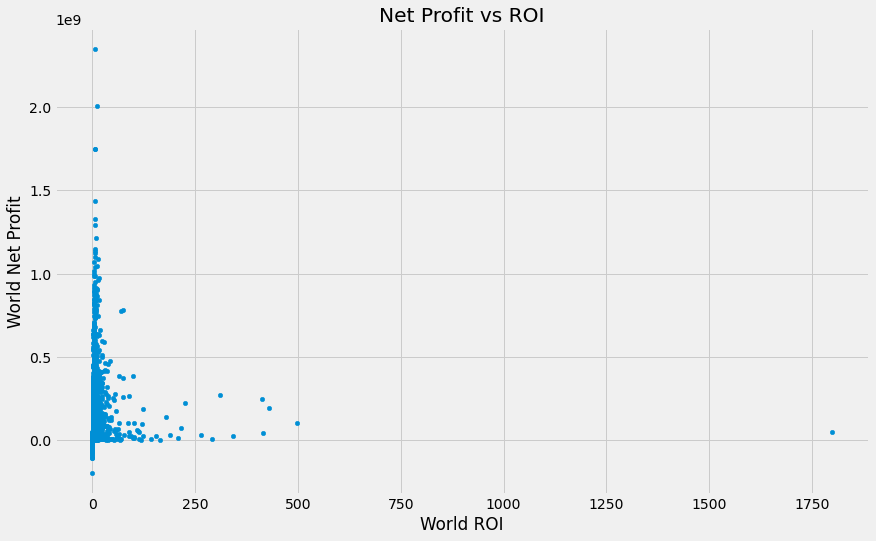

In [12]:
# Looking for placeholder values
tn_budgets.worldwide_gross.value_counts()

# Remove rows with placeholder values for domestic_gross
tn_budgets = tn_budgets.loc[tn_budgets['domestic_gross'] != 0]

ax = tn_budgets.plot.scatter(x='world_ROI', y='world_net_profit', 
                title='Net Profit vs ROI', figsize=(13,8))
ax.set_xlabel('World ROI')
ax.set_ylabel('World Net Profit')

We can see that these two features aren't correlated. In fact, there appear to be two distinct groups in the data:
1. high ROI (greater than ~100%), but relatively low net profits (less than ~250 million USD)
2. low ROI (less than ~50%), but high net profits (greater than ~500 million USD)

We need to investigate both groups a little more, but Microsoft will likely want to belong to the latter group (i.e., high net profit). Though films in that group had less impressive ROIs, they ultimately made a lot more money. I start by looking at the former group below.

In [13]:
# Select the top 10% of films by ROI.
top_ten_percent_ROI = tn_budgets.loc[tn_budgets.world_ROI 
                            >= tn_budgets.world_ROI.quantile(.9)].sort_values('world_ROI', ascending=False)
top_ten_percent_ROI.head(20)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,world_ROI,world_net_profit
5745,46,"Jun 30, 1972",Deep Throat,25000,45000000,45000000,1799.000000,44975000
5613,14,"Mar 21, 1980",Mad Max,200000,8750000,99750000,497.750000,99550000
5492,93,"Sep 25, 2009",Paranormal Activity,450000,107918810,194183034,430.517853,193733034
5679,80,"Jul 10, 2015",The Gallows,100000,22764410,41656474,415.564740,41556474
5406,7,"Jul 14, 1999",The Blair Witch Project,600000,140539099,248300000,412.833333,247700000
5709,10,"May 7, 2004",Super Size Me,65000,11529368,22233808,341.058585,22168808
5346,47,"Aug 13, 1942",Bambi,858000,102797000,268000000,311.354312,267142000
5773,74,"Feb 26, 1993",El Mariachi,7000,2040920,2041928,290.704000,2034928
5676,77,"Oct 1, 1968",Night of the Living Dead,114000,12087064,30087064,262.921614,29973064
5210,11,"Nov 21, 1976",Rocky,1000000,117235147,225000000,224.000000,224000000


It's just a rough, qualitative assessment, but right away I can see that movies with high ROI are often adult-oriented or horror (e.g., *Deep Throat*, *Paranormal Activity*, *The Blair Witch Projet*, etc.). This might not be the group of films Microsoft wants its own to belong to. Next I investigate the group of films that have high net profit.

In [14]:
# Select the top 10% of films by net profit.
top_ten_percent_net_profit = tn_budgets.loc[tn_budgets.world_ROI >= tn_budgets.world_ROI.quantile(.9)].sort_values(by=['world_ROI'], ascending=False)
top_ten_percent_net_profit.sort_values(by=['world_ROI'], ascending=False).head(20)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,world_ROI,world_net_profit
5745,46,"Jun 30, 1972",Deep Throat,25000,45000000,45000000,1799.000000,44975000
5613,14,"Mar 21, 1980",Mad Max,200000,8750000,99750000,497.750000,99550000
5492,93,"Sep 25, 2009",Paranormal Activity,450000,107918810,194183034,430.517853,193733034
5679,80,"Jul 10, 2015",The Gallows,100000,22764410,41656474,415.564740,41556474
5406,7,"Jul 14, 1999",The Blair Witch Project,600000,140539099,248300000,412.833333,247700000
5709,10,"May 7, 2004",Super Size Me,65000,11529368,22233808,341.058585,22168808
5346,47,"Aug 13, 1942",Bambi,858000,102797000,268000000,311.354312,267142000
5773,74,"Feb 26, 1993",El Mariachi,7000,2040920,2041928,290.704000,2034928
5676,77,"Oct 1, 1968",Night of the Living Dead,114000,12087064,30087064,262.921614,29973064
5210,11,"Nov 21, 1976",Rocky,1000000,117235147,225000000,224.000000,224000000


These appear to be more the group Microsoft should aim for. Again being fast and qualitative, these are high profit, high visibility films, often family oriented, often action oriented.

## Assembling DataFrames

Having a good idea of the setup of my tables, I begin combining tables, using the IMDB table of titles and IMDB-IDs as my starting point. I use the IMDB-ID to join with data on foreign titles and crew members, so I expect a high degree of integrity from those joins. I also join with data on revenue from a separate source that isn't indexed by IMDB-ID; I'm forced to join on movie title. This approach feels 'leakier' to me, as differences in spelling  and punctuation could result in loss of data (*e.g.*, *Star Wars 5* in one table and *Star Wars V* in another wouldn't be joined).

In [15]:
df = imdb_title_basics.set_index('tconst').join(imdb_foreign_titles)
# Dropping a redundant column from the imdb_foreign_titles table. 
df.drop(['title_id'], axis=1, inplace=True)
df.foreign_titles.fillna(value=0, inplace=True)
df = df.join(imdb_title_crew.set_index('tconst'))
df = df.join(tn_budgets.set_index('movie'), on='primary_title')

# Dropping the id column from the tn_budgets table. I'm not sure what the source is, but its ID system
# is not congruent to IMDB's.
df.drop(['id'], axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146306 entries, 0 to 146305
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   tconst             146306 non-null  object 
 1   primary_title      146306 non-null  object 
 2   original_title     146285 non-null  object 
 3   start_year         146306 non-null  int64  
 4   runtime_minutes    114543 non-null  float64
 5   genres             140895 non-null  object 
 6   foreign_titles     146306 non-null  float64
 7   directors          140577 non-null  object 
 8   writers            110392 non-null  object 
 9   release_date       3277 non-null    object 
 10  production_budget  3277 non-null    float64
 11  domestic_gross     3277 non-null    float64
 12  worldwide_gross    3277 non-null    float64
 13  world_ROI          3277 non-null    float64
 14  world_net_profit   3277 non-null    float64
dtypes: float64(7), int64(1), object(7)
memory usage: 17

I can see that, even with the leaky join, I still got 3277 titles with data on profit. This still seems reasonably large to me for the sake of early analysis.

## Making Groups of High and Low Net Profit 
Next, I make two new data frames, one for the top 25% of movies by net profit (quant_75_net_profit), and the other for the bottom 25% (quant_25_net_profit). These quantiles were chosen arbitrarily and could be made more or less strict at Microsoft's request.

In [16]:
quant_75_net_profit = df.loc[df.world_net_profit >= df.world_net_profit.quantile(.75)]
quant_25_net_profit = df.loc[df.world_net_profit <= df.world_net_profit.quantile(.25)]
print('Top 25% Net Profit:')
display(quant_75_net_profit.info())
print('Bottom 25% Net Profit')
display(quant_25_net_profit.info())

Top 25% Net Profit:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 821 entries, 33 to 146240
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tconst             821 non-null    object 
 1   primary_title      821 non-null    object 
 2   original_title     821 non-null    object 
 3   start_year         821 non-null    int64  
 4   runtime_minutes    744 non-null    float64
 5   genres             806 non-null    object 
 6   foreign_titles     821 non-null    float64
 7   directors          805 non-null    object 
 8   writers            740 non-null    object 
 9   release_date       821 non-null    object 
 10  production_budget  821 non-null    float64
 11  domestic_gross     821 non-null    float64
 12  worldwide_gross    821 non-null    float64
 13  world_ROI          821 non-null    float64
 14  world_net_profit   821 non-null    float64
dtypes: float64(7), int64(1), object(7)
memory usage: 1

None

Bottom 25% Net Profit
<class 'pandas.core.frame.DataFrame'>
Int64Index: 821 entries, 48 to 146099
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tconst             821 non-null    object 
 1   primary_title      821 non-null    object 
 2   original_title     820 non-null    object 
 3   start_year         821 non-null    int64  
 4   runtime_minutes    678 non-null    float64
 5   genres             803 non-null    object 
 6   foreign_titles     821 non-null    float64
 7   directors          796 non-null    object 
 8   writers            716 non-null    object 
 9   release_date       821 non-null    object 
 10  production_budget  821 non-null    float64
 11  domestic_gross     821 non-null    float64
 12  worldwide_gross    821 non-null    float64
 13  world_ROI          821 non-null    float64
 14  world_net_profit   821 non-null    float64
dtypes: float64(7), int64(1), object(7)
memory usage:

None

### A second question: who should direct?

After a bit of research into the movie making process, it seems that the director hires the actors for most projects, so I decided to focus on analyzing directors with the thought that picking a good director would trickle down to an equally good cast. To do that, I create a list of all my director IDs, and then map them back to the imdb_names table to get their names. Lastly I create a new DataFrame with the directors and the number of films they directed in the top 25% of movies by net profit.

In [17]:
top_directors = []
for directors in list(quant_75_net_profit.directors.dropna().array):
    top_directors = top_directors + directors.split(',')
for index, item in enumerate(top_directors):
    if item =='unlisted':
        top_directors[index] = item
    else:
        top_directors[index] = imdb_names.loc[imdb_names.nconst == top_directors[index], 'primary_name'].values[0]
top_directors = pd.Series(top_directors)

all_directors = []
for directors in list((df.dropna(subset=['world_net_profit'])).directors.dropna().array):
    all_directors = all_directors + directors.split(',')
for index, item in enumerate(all_directors):
    if item =='unlisted':
        all_directors[index] = item
    else:
        all_directors[index]= imdb_names.loc[imdb_names.nconst == all_directors[index], 'primary_name'].values[0]
all_directors = pd.Series(all_directors)

In [18]:
top_directors_df = pd.DataFrame(top_directors.unique(), columns=['director'])
top_directors_df = top_directors_df.set_index('director').join(pd.DataFrame(top_directors.value_counts()))
top_directors_df.reset_index(inplace=True)
top_directors_df.columns = ['director', 'count']

In [19]:
# Conditional probability for finding chances of producing a top netting film 
# given 0 or 1 previous top netting film.
a = len(all_directors.unique())
b = len(top_directors_df)
c = len(top_directors_df.loc[top_directors_df['count'] > 1])
d = len(top_directors_df.loc[top_directors_df['count'] > 2])

print('All directors = a = ' + str(a))
print('Directors of top net profit films = b = ' + str(b))
print('Directors with more than one top net profit film = c = ' + str(c))
print('Directors with more than two top net profit film = d = ' + str(d))

print('Chance of making a top net profit film = b/a = {}%'.format(str(round((100*b/a)))))
print('Chance of making a another top net profit film = c/b = {}%'.format(str(round(100*c/b))))
print('Chance of making a third top net profit film after making two = c/d = {}%'.format(str(round(100*d/c))))

top_directors_df.sort_values('count', ascending=False).\
        iplot(kind='bar', x='director', y='count', title='Directors of Top 25% Net Profit Films')

All directors = a = 2762
Directors of top net profit films = b = 683
Directors with more than one top net profit film = c = 150
Directors with more than two top net profit film = d = 57
Chance of making a top net profit film = b/a = 25%
Chance of making a another top net profit film = c/b = 22%
Chance of making a third top net profit film after making two = c/d = 38%


There are plenty of directors with at least one high profit film to choose from, **and for those who already have 2 top netting film to their names, chances of producing another top netting film jump from 25% to 38%**, a good argument for hiring a director who already has at least one high net profit film under his or her belt. 
<br/>

I take a quick look at  measures of centrality for high and low net profit films, looking for key places they might be different.

In [20]:
quant_25_net_profit.describe()

,start_year,runtime_minutes,foreign_titles,production_budget,domestic_gross,worldwide_gross,world_ROI,world_net_profit
count,821.000000,678.000000,821.000000,8.210000e+02,8.210000e+02,8.210000e+02,821.000000,8.210000e+02
mean,2014.423873,97.085546,8.533496,2.850347e+07,7.818979e+06,1.396386e+07,-0.616651,-1.453961e+07
std,2.780264,28.805748,10.053293,2.954177e+07,1.097337e+07,2.170065e+07,0.273688,1.550550e+07
min,2010.000000,3.000000,0.000000,2.000000e+06,3.880000e+02,1.242000e+03,-0.999862,-2.002376e+08
25%,2012.000000,87.000000,1.000000,1.000000e+07,3.733750e+05,1.427656e+06,-0.862012,-1.952803e+07
50%,2015.000000,98.000000,3.000000,2.000000e+07,3.484331e+06,6.982680e+06,-0.626439,-9.606304e+06
75%,2017.000000,111.000000,16.000000,3.800000e+07,1.050194e+07,1.652141e+07,-0.411486,-5.227654e+06
max,2021.000000,360.000000,49.000000,3.500000e+08,8.930212e+07,2.600021e+08,-0.024770,-1.989976e+06


In [21]:
quant_75_net_profit.describe()

,start_year,runtime_minutes,foreign_titles,production_budget,domestic_gross,worldwide_gross,world_ROI,world_net_profit
count,821.000000,744.000000,821.000000,8.210000e+02,8.210000e+02,8.210000e+02,821.000000,8.210000e+02
mean,2014.323995,104.017473,21.571255,7.744240e+07,1.346447e+08,3.398180e+08,8.248393,2.623756e+08
std,2.712172,28.267202,16.534630,6.535277e+07,1.048769e+08,3.001613e+08,19.964112,2.567758e+08
min,2010.000000,3.000000,0.000000,8.580000e+05,8.178001e+06,7.397524e+07,0.401932,6.977332e+07
25%,2012.000000,92.000000,1.000000,2.500000e+07,6.763116e+07,1.495707e+08,1.995511,1.057634e+08
50%,2014.000000,105.500000,28.000000,6.000000e+07,1.012000e+08,2.429818e+08,3.343896,1.655693e+08
75%,2017.000000,120.000000,36.000000,1.250000e+08,1.719584e+08,3.898704e+08,7.016044,3.026656e+08
max,2021.000000,180.000000,55.000000,4.250000e+08,7.605076e+08,2.776345e+09,311.354312,2.351345e+09


There's a noticeable difference in average number of foreign titles between the high and low netting groups. I plot them below for further analysis.
### A third question: are number of foriegn titles and net profit correlated?

(0.0, 490.0)

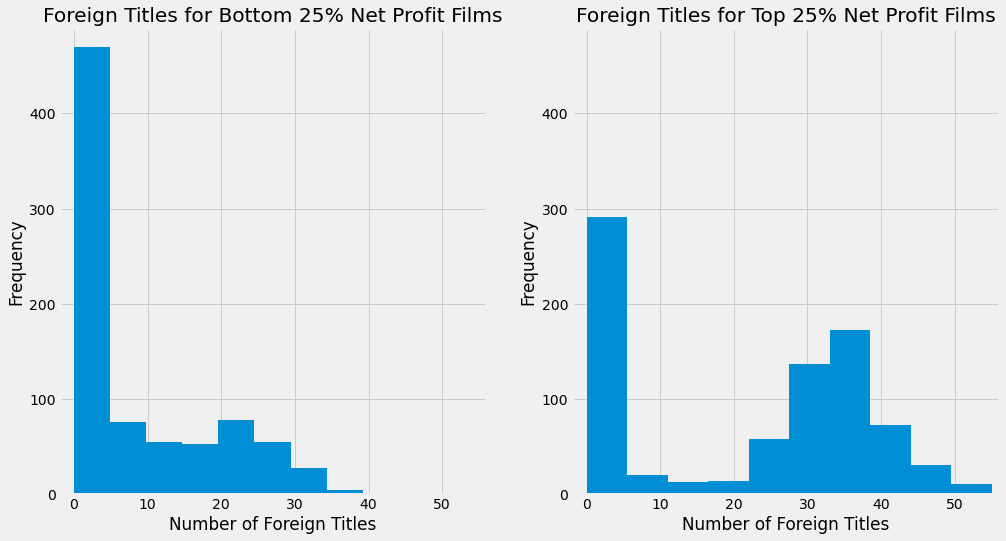

In [22]:
fig, axes = plt.subplots(1,2, figsize=(15,8))
quant_25_net_profit.foreign_titles.\
    plot(kind='hist', title='Foreign Titles for Bottom 25% Net Profit Films', ax=axes[0])
quant_75_net_profit.foreign_titles.\
    plot(kind='hist', title='Foreign Titles for Top 25% Net Profit Films', ax=axes[1])
axes[0].set_xlabel('Number of Foreign Titles')
axes[0].set_xlim(-2, 56)
axes[0].set_ylim(0, 490)
axes[1].set_xlabel('Number of Foreign Titles')
axes[1].set_xlim(-2, 56)
axes[1].set_ylim(0, 490)

**The difference between top and bottom net profitting films in number of foreign films is quite large, with top netting films more often having more foreign titles.** The bottom 25% net profit films have a unimodal distribution of foreign titles (somewhere between 0 and 5 titles) whereas the top 25% net profit films are bimodal with a peak between 0 and 5 titles and a second peak between 30 and 40 foreign titles. There's a bit of a chicken-and-egg problem to this situation: did high netting films do well in part because they tend to have more foreign titles, or do they have more foreign titles on average because of their box office success. Impossible to answer here, but I still think Microsoft should be aiming for more foreign titles, both for the potential financial success it might bring as well as the opportunity for branding in international markets.

## Exploring Genres
**Which genre has the best bet of becoming a top netting film?**

In [23]:
# Table of high ROI films for comparison with high net profit films later.
quant_75_ROI = df.loc[df.world_ROI >= df.world_ROI.quantile(.75)]

# Table for all films EXCEPT top 25% by net profit. Used for a stacked bar chart below.
genre_slice = df.loc[df.world_net_profit < df.world_net_profit.quantile(.75)]

# 4 lists of genres, some items being multiple genres separated by a comma. I have to separate these out later,
# so here I'm calling my lists "stacked." 
# List of genres for top 25% net profit films.
stacked_top_genres = list(quant_75_net_profit.genres.dropna().array)
# List of genres for bottom 25% net profit films.
stacked_bottom_genres = list(quant_25_net_profit.genres.dropna().array)
# List of genres for top 25% ROI films
stacked_top_ROI = list(quant_75_ROI.genres.dropna().array)
# List of genres for all films except those films in stacked_top_genres. (These are bottom 75% net profit films.)
stacked_bulk_genres = list(genre_slice.genres.dropna().array)

# Sort through each list above to turn single strings of multiple genres into individual strings.
top_genres = []
bottom_genres = []
top_ROI = []
bulk_genres = []
for item in stacked_top_genres:
    top_genres = top_genres + item.split(',')
for item in stacked_bottom_genres:
    bottom_genres += item.split(',')
for item in stacked_top_ROI:
    top_ROI += item.split(',')
for item in stacked_bulk_genres:
    bulk_genres += item.split(',')

top_genres = pd.Series(top_genres)
bottom_genres = pd.Series(bottom_genres)
top_ROI = pd.Series(top_ROI)
bulk_genres = pd.Series(bulk_genres)

In [24]:
# Take the Series of genres for each stratum of films and convert each into a DataFrame,
# including requency within the stratum as "count".

top_genres_df = pd.DataFrame(top_genres.unique(), columns=['genre'])
top_genres_df = top_genres_df.set_index('genre').join(pd.DataFrame(top_genres.value_counts()))
top_genres_df.reset_index(inplace=True)
top_genres_df.columns = ['genre', 'count']
top_genres_df['relative_frequency']=top_genres_df['count']/top_genres_df['count'].sum()

bottom_genres_df = pd.DataFrame(bottom_genres.unique(), columns=['genre'])
bottom_genres_df = bottom_genres_df.set_index('genre').join(pd.DataFrame(bottom_genres.value_counts()))
bottom_genres_df.reset_index(inplace=True)
bottom_genres_df.columns = ['genre', 'count']
bottom_genres_df['relative_frequency']=bottom_genres_df['count']/bottom_genres_df['count'].sum()

top_ROI_df = pd.DataFrame(top_ROI.unique(), columns=['genre'])
top_ROI_df = top_ROI_df.set_index('genre').join(pd.DataFrame(top_ROI.value_counts()))
top_ROI_df.reset_index(inplace=True)
top_ROI_df.columns = ['genre', 'count']
top_ROI_df['relative_frequency']=top_ROI_df['count']/top_ROI_df['count'].sum()

bulk_genres_df = pd.DataFrame(bulk_genres.unique(), columns=['genre'])
bulk_genres_df = bulk_genres_df.set_index('genre').join(pd.DataFrame(bulk_genres.value_counts()))
bulk_genres_df.reset_index(inplace=True)
bulk_genres_df.columns = ['genre', 'count']
bulk_genres_df['relative_frequency']=bulk_genres_df['count']/bulk_genres_df['count'].sum()

Text(0, 0.5, 'Relative Frequency')

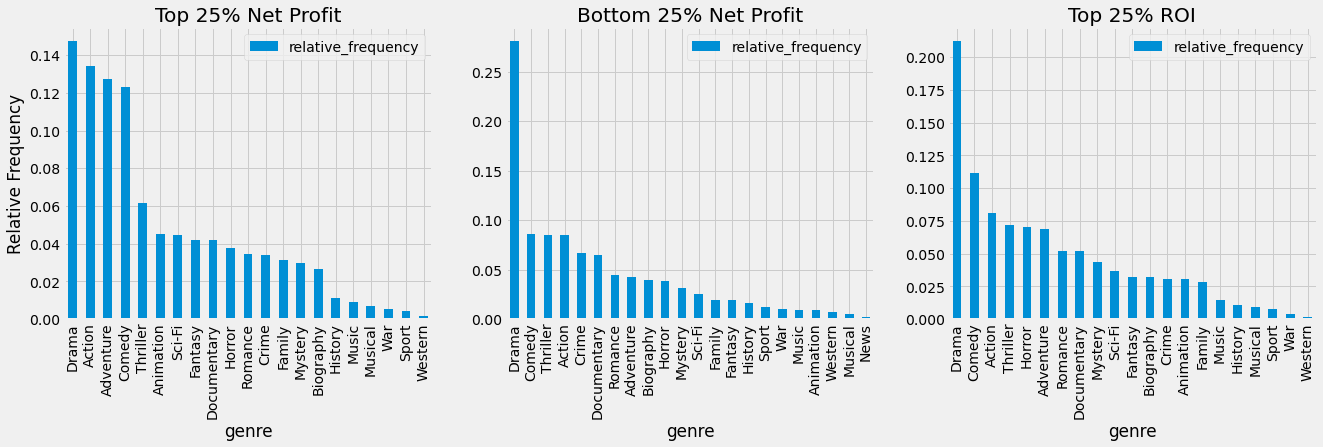

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5))
top_genres_df.sort_values(by='relative_frequency', ascending=False).plot.bar(
    x='genre', y='relative_frequency', title= 'Top 25% Net Profit', ax=axes[0])
bottom_genres_df.sort_values(by='relative_frequency', ascending=False).plot.bar(
    x='genre', y='relative_frequency', title='Bottom 25% Net Profit', ax=axes[1])
top_ROI_df.sort_values(by='relative_frequency', ascending=False).plot.bar(
    x='genre', y='relative_frequency', title='Top 25% ROI', ax=axes[2])
axes[0].set_ylabel('Relative Frequency')

There are some big differences in the relative frequency of each genre between the films with **top 25% net profit (far left above)** and the **bottom 25% (middle)**. Drama was the most common genre in both, but it leads but a much larger ROI in bottom 25% films. On the other hand, action makes up a much larger portion of top films, ~13% compared to ~8% for bottom films. Out of curiosity, I've also plotted the relative distribution of genres for films in the **top 25% for _ROI_ (right)**. Interestingly, its distribution of genres rather closely resembles the bottom 25% of net profit films' distribution, with drama, comedy, and thriller movies all having greater presence than they do in the top 25% for net profit. I consider this more incentive to steer clear of a high ROI film for Microsoft's goal. 
<br/><br/>

One thing to note is that above I've plotted the relative frequency of each genre *within the given stratum*. To take an example for the sake of clarity, of all the films in the top 25% for net profit (far left above), approximately 15% of them were drama. This is *not* to say that of all drama films, 15% of them were in the top 25% for net profit. To get a feel for this new distinction–what portion of all drama films wind up in the top 25% for net profit–I plot the raw frequency of each genre for all films for which I have data on profit. I've highlighted the portion of them that are in the top 25% of net profit in orange at the top of each bar.

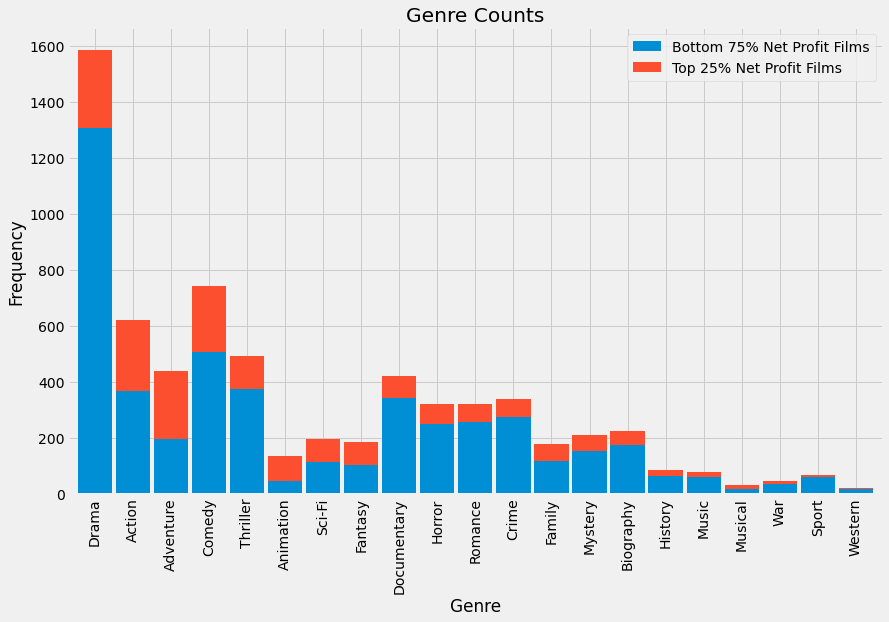

In [26]:
all_genres_df = top_genres_df.set_index('genre').\
    join(bulk_genres_df.set_index('genre'), lsuffix='top', rsuffix='bulk')
width = .9
ax = all_genres_df.sort_values('relative_frequencytop', ascending=False).loc[:, ['countbulk', 'counttop']].\
    plot.bar(stacked=True, width=width, title='Genre Counts', figsize=(13,8))
ax.set_xlabel('Genre')
ax.set_ylabel('Frequency')
ax.legend(['Bottom 75% Net Profit Films', 'Top 25% Net Profit Films'])

Without producing any statistical analyses, it's still quite easy to see that, **while drama is the most populous genre in top netting films, drama films do not, as a whole, stand a good chance of making top net profit**, and neither do comedy nor thriller films. **Action, adventure, animation, and even sci-fi and fantasy movies have a much better portion of their films making into the top netting bracket.**
<br/>

## Finding the Right Keywords

Next, I create a new feature, tconst_int, which is the IMDB-ID feature recast as integers. I'll need it to an join with another table that I got from Kaggle which has already converted its IMDB-IDs to integers. This particular data has keyword data, and I'm eager to analyze those. Credits to [Kaggle](https://www.kaggle.com) and its [The Movie Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) and to my colleague Edward Amor for the below use of regex

In [27]:
def integerizer(my_string):
    '''Strips a string of all non-numerical characters. Returns a string.'''
    return re.sub(r"[^0-9.]", "", my_string)

# Strip my tconst field of letters and convert to type int.
df['tconst_int'] = df.tconst.apply(integerizer).astype('int')

In [28]:
# Read two tables from a Kaggle dataset. links_small is a map for converting their internal ID system
# to the IMDB ID system.
tmd_imbd_map_df = pd.read_csv('Data/kaggle_the_movies_dataset/links_small.csv').set_index('movieId')
tmd_keywords_df = pd.read_csv('Data/kaggle_the_movies_dataset/keywords.csv').set_index('id')
tmd_df = tmd_keywords_df.join(tmd_imbd_map_df)
tmd_df.set_index('imdbId', inplace=True)

# Combine the data with my master DataFrame. 
df = df.set_index('tconst_int').join(tmd_df)
df = df.sort_values(by=['world_net_profit', 'foreign_titles'], ascending=False).drop_duplicates(
    subset='primary_title')
df.loc[df.world_net_profit >= df.world_net_profit.quantile(.75)].head(20)

# Update quant_25_net_profit and quant_75_net_profit DataFrames with the new feature.
quant_25_net_profit = df.loc[df.world_net_profit <= df.world_net_profit.quantile(.25)]
quant_75_net_profit = df.loc[df.world_net_profit >= df.world_net_profit.quantile(.75)]

In [29]:
'''Entries under "keywords" are lists of dictionaries, but they're currently coded as strings.

e.g., [{'id':int, 'name':str}, 
       {'id':int, 'name':str}, 
       ...] all as one long string: "[{'id':int,'name':str},...]"

I put all "keywords" entries for top net profit films into a list and evaluate them out of string format.''' 
top_keywords = list(quant_75_net_profit.loc[quant_75_net_profit.keywords.notna(), 'keywords'])
for index, item in enumerate(top_keywords):
    top_keywords[index] = eval(item)

# Loop through my list of (lists of dictionaries) to put each individual keyword into a separate list.
list_of_top_keywords = []
for item in top_keywords:
    # as long as the list isn't empty:
    if item:
        for subitem in item:
            list_of_top_keywords.append(subitem['name'])
            
list_of_top_keywords = pd.Series(list_of_top_keywords)
list_of_top_keywords

0                     bullet
1                      arrow
2                    archery
3              class reunion
4                   gunfight
5        hand to hand combat
6                special ops
7               gulf war vet
8              time traveler
9            new delhi india
10    himachal pradesh india
11                    punjab
12              punjab india
13      narration from grave
14                 slapstick
15                teen angst
16                 slaughter
17               dark comedy
18        supernatural being
19              killer clown
20           revenge killing
21                     hotel
22                     haiti
23               supermarket
24                     fight
25         product placement
26        computer animation
27                      food
28                head wound
29                  criminal
30            security guard
31                contraband
32                   vampire
33                  reindeer
34            

In [30]:
# Repeat the above process for bottom net profit films.

bottom_keywords = list(quant_25_net_profit.loc[quant_25_net_profit.keywords.notna(), 'keywords'])
for index, item in enumerate(bottom_keywords):
    bottom_keywords[index] = eval(item)
    
list_of_bottom_keywords = []
for item in bottom_keywords:
    if item:
        for subitem in item:
            list_of_bottom_keywords.append(subitem['name'])
            
list_of_bottom_keywords = pd.Series(list_of_bottom_keywords)
list_of_bottom_keywords

0            prostitute
1            undercover
2                nudity
3          exploitation
4               revenge
5                murder
6                  gang
7               lesbian
8                  drug
9               hideout
10        female nudity
11              sheriff
12                snake
13               nudity
14            alligator
15                swamp
16              revenge
17             violence
18       attempted rape
19    exploitation film
20               incest
21                cajun
dtype: object

There isn't a very clear association between keywords for high net profit films, but there is for low net profit. In short, they tend to be much more adult oriented, being both more sexual and violent. There's a big problem with these two sets of data though, and it's that they're both alarmingly small; there are only 35 and 22 keywords for high and low net profit films respectively. This is scant little information to be making decisions on.

Unsatisfied with this dataset, I started looking for other sources of keyword data. One option was IMBD, but they appear [stricter](https://www.imdb.com/licensing/) in the control of their data than I'm interested in dealing with at this time. As an alternative, I found that [The Movie Database](https://www.themoviedb.org/documentation/api?language=en-US) gives free and instant access to their data, and includes keyword and IMBD-ID data for their movies. This should be an easy dataset to join with mine. Below, I interact with their API to get keyword data for the movies in my dataset.

(N.B. I left the original code making API calls to showcase my work as a module project for Flatiron School, but if the code stops working for any reason–the API changes, the data changes, etc.–the data I originally worked with has been saved as a CSV file in data as tmdb_keyword_data.csv.)

In [33]:
# Saving the API key I have for accessing TMDB for quick access.
with open('/Users/stlanier/.secret/tmdb_api.json') as f: 
    api_key = json.load(f)['api_key']

In [36]:
def get_keywords(imdb_ids, api_key):
    '''
    Given a list of movie IMDB-IDs and an api_key, returns a list of associated keywords from The Movie Database.
    
        Parameters:
            imdb_ids (list): A list of IMDB-IDs as strings for all the movies you want keywords for.
            api_key (str): Your API key for accessing The Movie Database's API.
        
        Returns:
            keywords (list): a list of all keywords (str) associated with all movies in imdb_ids.
    
    '''
    tmdb_ids = []
    keywords = []
    
    # First get a list of TMDB's internal IDs for all the movies in imdb_ids.
    for imdb_id in imdb_ids:
        url_for_find = 'https://api.themoviedb.org/3/find/{}?api_key={}&language=en-US&external_source=imdb_id'.format(imdb_id, api_key)
        response = requests.get(url_for_find).json()
        if response['movie_results']:
            tmdb_ids.append(response['movie_results'][0]['id'])
    
    # Next get the keywords for each movie.
    for tmdb_id in tmdb_ids:
        url_for_keywords = 'https://api.themoviedb.org/3/movie/{}/keywords?api_key={}'.format(tmdb_id, api_key)
        response = requests.get(url_for_keywords).json()
        if response:
            for keyword in response['keywords']:
                keywords.append(keyword['name'])
    return keywords

In [37]:
top_keywords = get_keywords(list(quant_75_net_profit['tconst']), api_key)

In [38]:
bottom_keywords = get_keywords(list(quant_25_net_profit['tconst']), api_key)

In [48]:
all_keywords = get_keywords(list(df.loc[df.world_net_profit.notna()]['tconst']), api_key)

In [54]:
print('Keywords in top 25% net profit films: ' + str(len(top_keywords)))
print('Keywords in bottom 25% net profit films: ' + str(len(bottom_keywords)))
print('Keywords in all films: ' + str(len(all_keywords)))

Keywords in top 25% net profit films: 4564
Keywords in bottom 25% net profit films: 2641
Keywords in all films: 5027


This is a much more robust set of data. Onward!

In [52]:
# DataFrame of keywords and counts for all movies I have revenue data on.
all_keywords = pd.Series(all_keywords)
all_keywords_df = pd.DataFrame(all_keywords.unique(), columns=['keyword'])
all_keywords_df = all_keywords_df.set_index('keyword').join(pd.DataFrame(all_keywords.value_counts()))
all_keywords_df.reset_index(inplace=True)
all_keywords_df.columns = ['keyword', 'count']
all_keywords_df.sort_values(by=['count'], ascending=False, inplace=True)
all_keywords_df.set_index('keyword', inplace=True)
all_keywords_df.drop(['duringcreditsstinger', 'aftercreditsstinger'], axis=0, inplace=True)

# Just keywords and counts for the top 25% net profit films.
top_keywords = pd.Series(top_keywords)
top_keywords_df = pd.DataFrame(top_keywords.unique(), columns=['keyword'])
top_keywords_df = top_keywords_df.set_index('keyword').join(pd.DataFrame(top_keywords.value_counts()))
top_keywords_df.reset_index(inplace=True)
top_keywords_df.columns = ['keyword', 'top_count']
top_keywords_df.sort_values(by=['top_count'], ascending=False, inplace=True)
top_keywords_df.set_index('keyword', inplace=True)
top_keywords_df.drop(['duringcreditsstinger', 'aftercreditsstinger'], axis=0, inplace=True)

# Just keywords and counts for the bottom 25% net profit films.
bottom_keywords = pd.Series(bottom_keywords)
bottom_keywords_df = pd.DataFrame(bottom_keywords.unique(), columns=['keyword'])
bottom_keywords_df = bottom_keywords_df.set_index('keyword').join(pd.DataFrame(bottom_keywords.value_counts()))
bottom_keywords_df.reset_index(inplace=True)
bottom_keywords_df.columns = ['keyword', 'bottom_count']
bottom_keywords_df.sort_values(by=['bottom_count'], ascending=False, inplace=True)
bottom_keywords_df.set_index('keyword', inplace=True)
bottom_keywords_df.drop(['duringcreditsstinger', 'aftercreditsstinger'], axis=0, inplace=True)

# Join all 3 DataFrames, producing a keyword, count, 
# top_count (count in top 25% net profit), and bottom_count (count in bottom 25% net profit)
all_keywords_df = all_keywords_df.join(top_keywords_df)
all_keywords_df = all_keywords_df.join(bottom_keywords_df)
all_keywords_df.fillna(0, inplace=True)
# 2 new features that calculate 1) the fraction of a keywords appearances in top 25% net profit films
# and 2) the fraction of a keywords appearances in bottom 25% net profit films.
all_keywords_df['top_relative_frequency'] = all_keywords_df['top_count']/all_keywords_df['count']
all_keywords_df['bottom_relative_frequency'] = all_keywords_df['bottom_count']/all_keywords_df['count']

Text(0.5, 0, '')

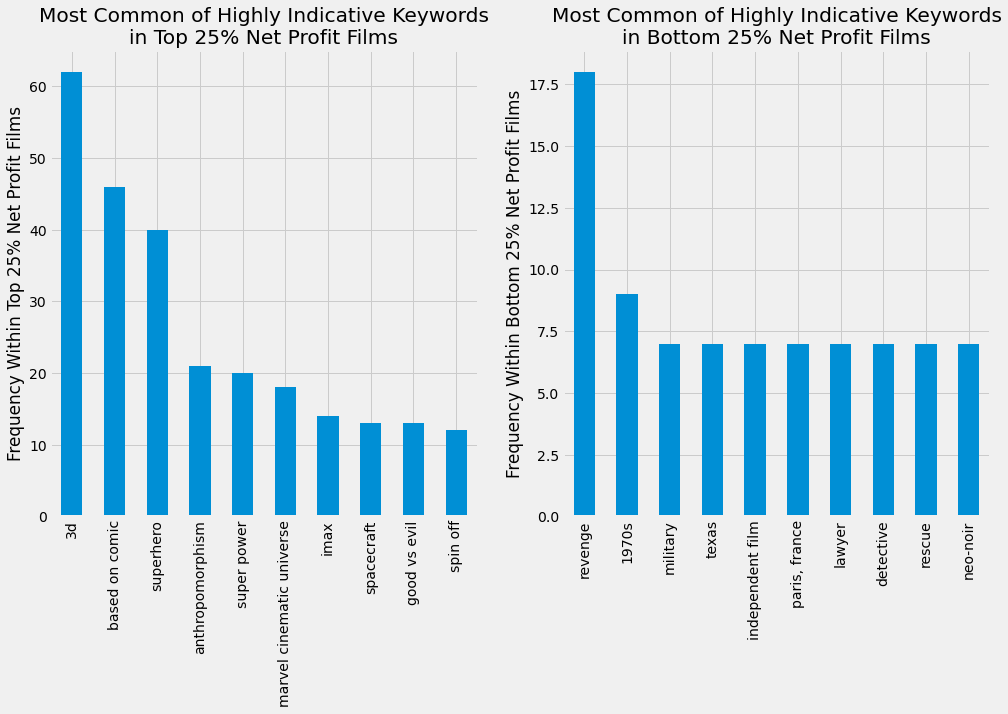

In [55]:
fig, axes = plt.subplots(1,2, figsize=(15,8))
all_keywords_df.reset_index(inplace=True)
# First I select the keywords that have the highest fractional appearances in top 25% net profit films
# (e.g., of all this keyword's appearances, 50% of them are in high net profit films),
# and then I plot the frequency (in top netting films) of the 10 most common of those keywords.
all_keywords_df.loc[all_keywords_df.top_relative_frequency 
                    >= all_keywords_df.top_relative_frequency.quantile(.75)].\
                    sort_values(by=['top_count', 'top_relative_frequency'], ascending=False).iloc[:10, :].\
                    plot.bar(x='keyword', y='top_count', 
                             title='Most Common of Highly Indicative Keywords\nin Top 25% Net Profit Films', 
                             ax=axes[0], legend=False)
all_keywords_df.loc[all_keywords_df.bottom_relative_frequency 
                    >= all_keywords_df.bottom_relative_frequency.quantile(.75)].\
                    sort_values(by=['bottom_count', 'bottom_relative_frequency'], ascending=False).iloc[:10, :].\
                    plot.bar(x='keyword', y='bottom_count', 
                             title='Most Common of Highly Indicative Keywords\nin Bottom 25% Net Profit Films', 
                             ax=axes[1], legend=False)
axes[0].set_ylabel('Frequency Within Top 25% Net Profit Films')
axes[0].set_xlabel('')
axes[1].set_ylabel('Frequency Within Bottom 25% Net Profit Films')
axes[1].set_xlabel('')

### A final question: what do keyword trends reveal about high net profit films?
Of the keywords I gathered, first I selected **highly indicative keywords** for each group. These keywords, when they appeared, were indicative of a high or a low net profitting film, depending, 75% of the time or better. Next, I picked *the most frequently occuring (most common)* of these keywords and plotted the frequency of each (in high or low net profit films, depending), and plotted the top 10 for each group above. An example for clarity: When the keyword '3d' is attached to a movie, at least 75% of the time that movie is in the top 25% for net profit. It's also the most common of such highly indicative keywords, appearing in high net profit films some 60+ times. Comparing the two sets of keywords above, many qualitative conclusions can be drawn, but what jumps out at me is that **high profit films tend to offer a 3D and/or IMAX viewing option, they tend to be classic Good vs Evil plots, and superhero and superpower movies are doing particularly well** (or Marvel is doing a great job claiming that as their signature keyword). On the other end of the spectrum, **noir/neo-noir themes, revenge and rescue plots, and lawyer/detective (drama?) elements seem to be more common among low profit films**. 

## Conclusions
Microsoft is a big company, so they stand to gain more net proft by investing big and aiming for **high net profit** over a high ROI. Towards that goal, I hypothesize that they can increase their chances of producing a successful film by focusing on features that are common among other highly successful features. 
- Some genres have a higher chance than others at producing high net profit films. Genres with some of the highest proportion of high net profit films were **action, adventure, animation, fantasy, and sci-fi**.
- Chosen at random, a director has a 25% chance of producing a high net profit film, defined in this analysis as film with net profit in the top 25% of all movies analyzed. **By choosing a director with at least two other high net profit film to his or her name, those chances increase to 38%**.
- Lastly, keywords (chosen by the producers of the movie) were examined for high and low net profit films, and a unique set of highly indicative keywords was associated with each group. When these keywords were associated with a movie, 75% of the time or better, they indicated a high net profit or a low net profit film, respectively. Some of the most common of the highly indicative keywords for high net profit films included **3D and IMAX, superheroes, and good vs. evil**. Highly indicative keywords for low net profit films included revenge, rescue, lawyer, detective, Paris, and neo-noir.

## Future Work
Below is a plot of net profit against production budget. There appears to be a moderately positive association between the two features, suggesting that, as a general rule, more investment in a movie turns out a higher net profit. In the future I'd like to use **linear regression** to make a model for predicting, based on the amount of money Microsoft wants to invest in a film, the net profit they can reasonably expect.

Text(0, 0.5, 'Net Profit Worldwide')

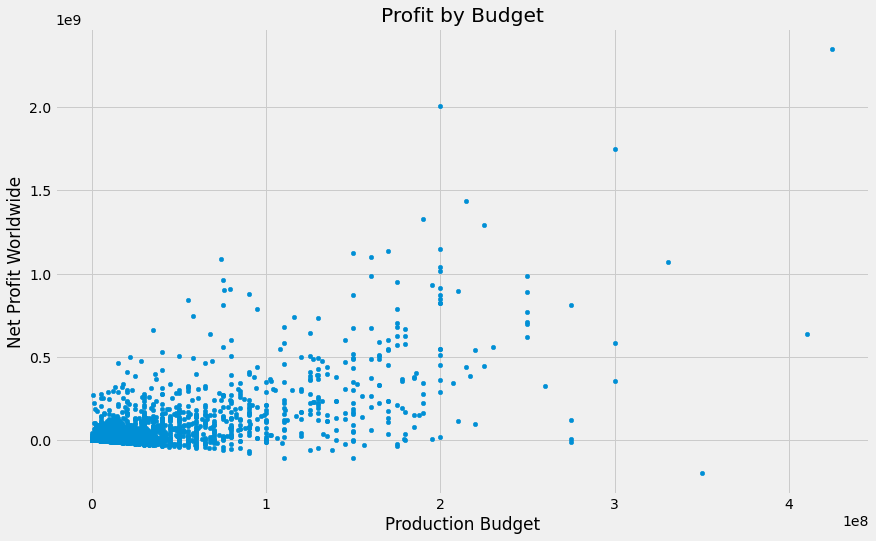

In [56]:
fig = df.plot(kind='scatter', x='production_budget', y='world_net_profit', title='Profit by Budget', figsize=(13,8))
fig.set_xlabel('Production Budget')
fig.set_ylabel('Net Profit Worldwide')
# df.iplot(kind='scatter', x='production_budget', y='world_net_profit', legend='primary_title')

In [57]:
df.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,foreign_titles,directors,writers,release_date,production_budget,domestic_gross,worldwide_gross,world_ROI,world_net_profit,keywords,tmdbId
1775309,tt1775309,Avatar,Abatâ,2011,93.0,Horror,3.0,nm3786927,"nm2179863,nm4392664","Dec 18, 2009",425000000.0,760507625.0,2.776345e+09,5.532577,2.351345e+09,NaN,NaN
2495766,tt2495766,Titanic,Titanic,2012,NaN,Adventure,1.0,"nm4430776,nm5410036",nm5410036,"Dec 19, 1997",200000000.0,659363944.0,2.208208e+09,10.041042,2.008208e+09,NaN,NaN
4154756,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",38.0,"nm0751577,nm0751648","nm1321655,nm1321656,nm0498278,nm0456158,nm0800...","Apr 27, 2018",300000000.0,678815482.0,2.048134e+09,5.827114,1.748134e+09,NaN,NaN
369610,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",48.0,nm1119880,"nm0415425,nm0798646,nm1119880,nm2081046,nm0000341","Jun 12, 2015",215000000.0,652270625.0,1.648855e+09,6.669092,1.433855e+09,NaN,NaN
2820852,tt2820852,Furious 7,Furious Seven,2015,137.0,"Action,Crime,Thriller",51.0,nm1490123,"nm0604555,nm0860155","Apr 3, 2015",190000000.0,353007020.0,1.518723e+09,6.993278,1.328723e+09,NaN,NaN
